# Evaluation of the detector

In [28]:
import sys
from itertools import chain
from pathlib import Path

sys.path.append(str(Path('../tools/detector').absolute()))
sys.path.append(str(Path('../tools/aletheia').absolute()))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from detect import detect_tools

## Load data

In [29]:
BASE_PATH = Path('../datasets/StegoAppDB_stegos_20240309-030352')
CONFIG = Path('../tools/detector/rules/stegoapps.yaml')

df = pd.read_csv(BASE_PATH / 'StegoAppDB_stegos_20240309-030352_stego_directory.csv')

methods = df['embedding_method'].unique()
all_pairs = {
    method: list(
        ((BASE_PATH / 'covers' / row.cover_image_filename).absolute(),
         (BASE_PATH / 'stegos' / row.image_filename).absolute())
        for row in df[df['embedding_method'] == method].itertuples()
    )
    for method in methods
}
all_pairs

{'MobiStego': [(PosixPath('/Users/fabianloewe/Projects/master-thesis/notebooks/../datasets/StegoAppDB_stegos_20240309-030352/covers/260507.PNG'),
   PosixPath('/Users/fabianloewe/Projects/master-thesis/notebooks/../datasets/StegoAppDB_stegos_20240309-030352/stegos/260508.PNG')),
  (PosixPath('/Users/fabianloewe/Projects/master-thesis/notebooks/../datasets/StegoAppDB_stegos_20240309-030352/covers/260507.PNG'),
   PosixPath('/Users/fabianloewe/Projects/master-thesis/notebooks/../datasets/StegoAppDB_stegos_20240309-030352/stegos/260509.PNG')),
  (PosixPath('/Users/fabianloewe/Projects/master-thesis/notebooks/../datasets/StegoAppDB_stegos_20240309-030352/covers/260507.PNG'),
   PosixPath('/Users/fabianloewe/Projects/master-thesis/notebooks/../datasets/StegoAppDB_stegos_20240309-030352/stegos/260510.PNG')),
  (PosixPath('/Users/fabianloewe/Projects/master-thesis/notebooks/../datasets/StegoAppDB_stegos_20240309-030352/covers/260507.PNG'),
   PosixPath('/Users/fabianloewe/Projects/master-thes

In [30]:
print('Pairs in total:', len([pair for pairs in all_pairs.values() for pair in pairs]))
for method, pairs in all_pairs.items():
    print(f'{method} pairs:', len(pairs))

Pairs in total: 18570
MobiStego pairs: 3060
PixelKnot pairs: 3060
PocketStego pairs: 3060
Pictograph pairs: 4800
SteganographyM pairs: 3060
Passlok pairs: 1530


In [31]:
data = {method: list(detect_tools(pairs, CONFIG)) for method, pairs in all_pairs.items()}
data

{'MobiStego': [Detection(cover=PosixPath('/Users/fabianloewe/Projects/master-thesis/notebooks/../datasets/StegoAppDB_stegos_20240309-030352/covers/260507.PNG'), stego=PosixPath('/Users/fabianloewe/Projects/master-thesis/notebooks/../datasets/StegoAppDB_stegos_20240309-030352/stegos/260508.PNG'), weights={'PocketStego': 1, 'MobiStego': 2}, matched_rules=['ISA.PocketStego-MobiStego.File-Size-Diff', 'ISA.MobiStego.LSB-Signature']),
  Detection(cover=PosixPath('/Users/fabianloewe/Projects/master-thesis/notebooks/../datasets/StegoAppDB_stegos_20240309-030352/covers/260507.PNG'), stego=PosixPath('/Users/fabianloewe/Projects/master-thesis/notebooks/../datasets/StegoAppDB_stegos_20240309-030352/stegos/260509.PNG'), weights={'PocketStego': 1, 'MobiStego': 2}, matched_rules=['ISA.PocketStego-MobiStego.File-Size-Diff', 'ISA.MobiStego.LSB-Signature']),
  Detection(cover=PosixPath('/Users/fabianloewe/Projects/master-thesis/notebooks/../datasets/StegoAppDB_stegos_20240309-030352/covers/260507.PNG'),

## Evaluation metrics treating weights as boolean values

If the weight of a method is greater than 0, the method is considered to be detected. Otherwise, it is not detected.

In [32]:
def get_stats_bool(data):
    all_detections = [(m, d) for m, detections in data.items() for d in detections]
    stats = {}
    for method, detections in data.items():
        stats[method] = {
            'true_positives': sum(m == method and d.weights.get(method, 0) > 0 for m, d in all_detections),
            'false_positives': sum(m != method and d.weights.get(method, 0) > 0 for m, d in all_detections),
            'false_negatives': sum(m == method and d.weights.get(method, 0) == 0 for m, d in all_detections),
            'true_negatives': sum(m != method and d.weights.get(method, 0) == 0 for m, d in all_detections)
        }
    return stats


stats = get_stats_bool(data)
stats

{'MobiStego': {'true_positives': 2751,
  'false_positives': 5611,
  'false_negatives': 309,
  'true_negatives': 9899},
 'PixelKnot': {'true_positives': 2907,
  'false_positives': 1484,
  'false_negatives': 153,
  'true_negatives': 14026},
 'PocketStego': {'true_positives': 2753,
  'false_positives': 1483,
  'false_negatives': 307,
  'true_negatives': 14027},
 'Pictograph': {'true_positives': 4560,
  'false_positives': 3628,
  'false_negatives': 240,
  'true_negatives': 10142},
 'SteganographyM': {'true_positives': 1444,
  'false_positives': 5895,
  'false_negatives': 1616,
  'true_negatives': 9615},
 'Passlok': {'true_positives': 1320,
  'false_positives': 0,
  'false_negatives': 210,
  'true_negatives': 17040}}

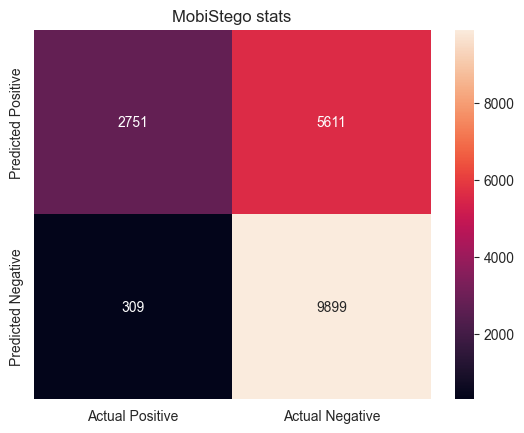

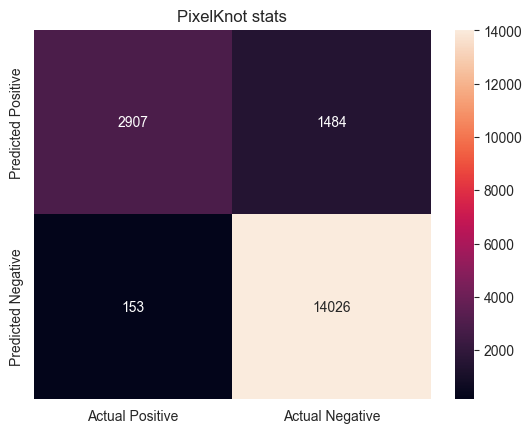

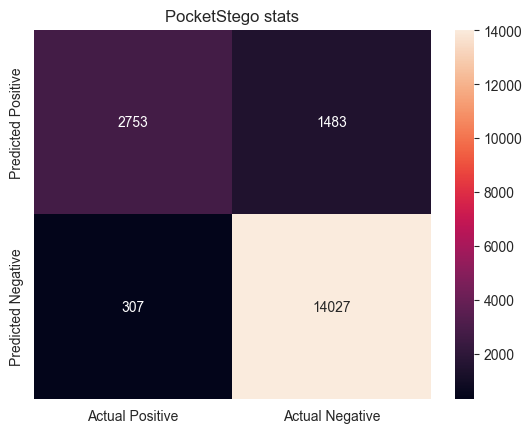

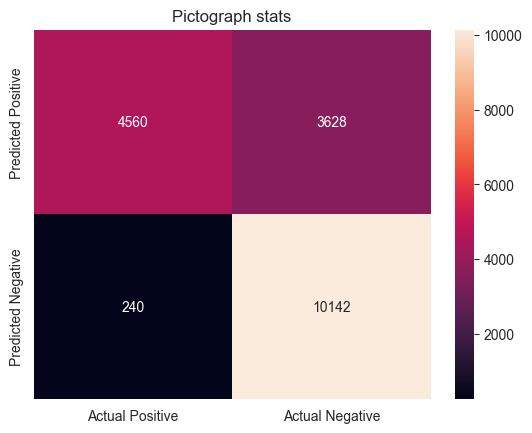

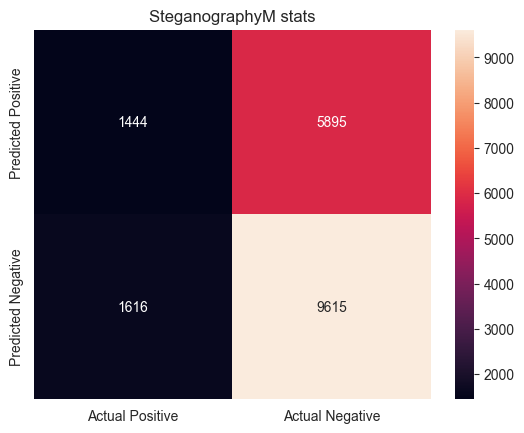

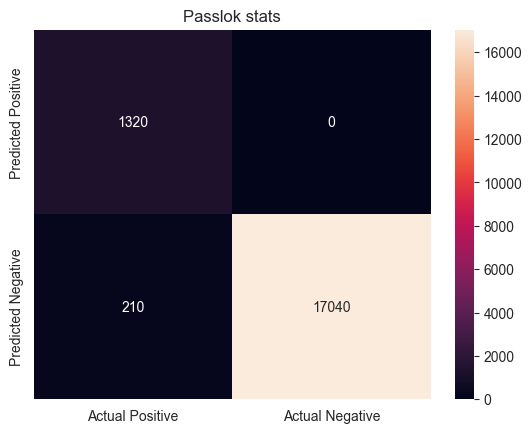

In [33]:
for method, stat in stats.items():
    stat_df = pd.DataFrame(
        [[stat['true_positives'], stat['false_positives']], [stat['false_negatives'], stat['true_negatives']]],
        columns=['Actual Positive', 'Actual Negative'], index=['Predicted Positive', 'Predicted Negative'])
    sns.heatmap(stat_df, annot=True, fmt='d')
    plt.title(f'{method} stats')
    plt.savefig(f'../assets/images/eval-detect_bool_{method.lower()}.png')
    plt.show()


In [34]:
stats2 = []

for method, stat in stats.items():
    try:
        accuracy = (stat['true_positives'] + stat['true_negatives']) / (
                    stat['true_positives'] + stat['false_positives'] + stat['true_negatives'] + stat['false_negatives'])
    except ZeroDivisionError:
        accuracy = 0

    try:
        precision = stat['true_positives'] / (stat['true_positives'] + stat['false_positives'])
    except ZeroDivisionError:
        precision = 0

    try:
        recall = stat['true_positives'] / (stat['true_positives'] + stat['false_negatives'])
    except ZeroDivisionError:
        recall = 0

    #f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    stats2.append((method, accuracy, precision, recall))
    
stats_df = pd.DataFrame(stats2, columns=['Method', 'Accuracy', 'Precision', 'Recall', 'F1'])
stats_df.to_csv('../assets/tables/eval-detect_bool.csv', index=False)
stats_df

ValueError: 5 columns passed, passed data had 4 columns

## Evaluation metrics accounting for weights

If the weight of a method is the highest among all methods, the method is considered to be detected. Otherwise, it is not detected. If the highest weight is shared by multiple methods, the detection is considered to be ambiguous and
no method is considered to be detected.

In [ ]:
def get_stats_max(data):
    def get_max_weight(detection):
        max_weight = max(detection.weights.values() or [0])
        if list(detection.weights.values()).count(max_weight) > 1:
            return None
        return max_weight if max_weight > 0 else None
    
    all_detections = [(m, d) for m, detections in data.items() for d in detections]
    stats = {}
    for method, detections in data.items():
        stats[method] = {
            'true_positives': sum(m == method and d.weights.get(method, 0) == get_max_weight(d) for m, d in all_detections),
            'false_positives': sum(m != method and d.weights.get(method, 0) == get_max_weight(d) for m, d in all_detections),
            'false_negatives': sum(m == method and d.weights.get(method, 0) != get_max_weight(d) for m, d in all_detections),
            'true_negatives': sum(m != method and d.weights.get(method, 0) != get_max_weight(d) for m, d in all_detections)
        }
    return stats


stats = get_stats_max(data)
stats

In [ ]:
for method, stat in stats.items():
    stat_df = pd.DataFrame(
        [[stat['true_positives'], stat['false_positives']], [stat['false_negatives'], stat['true_negatives']]],
        columns=['Actual Positive', 'Actual Negative'], index=['Predicted Positive', 'Predicted Negative'])
    sns.heatmap(stat_df, annot=True, fmt='d')
    plt.title(f'{method} stats')
    plt.savefig(f'../assets/images/eval-detect_max_{method.lower()}.png')
    plt.show()

In [ ]:
stats2 = []

for method, stat in stats.items():
    try:
        accuracy = (stat['true_positives'] + stat['true_negatives']) / (
                    stat['true_positives'] + stat['false_positives'] + stat['true_negatives'] + stat['false_negatives'])
    except ZeroDivisionError:
        accuracy = 0

    try:
        precision = stat['true_positives'] / (stat['true_positives'] + stat['false_positives'])
    except ZeroDivisionError:
        precision = 0

    try:
        recall = stat['true_positives'] / (stat['true_positives'] + stat['false_negatives'])
    except ZeroDivisionError:
        recall = 0

    #f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    stats2.append((method, accuracy, precision, recall))
    
stats_df = pd.DataFrame(stats2, columns=['Method', 'Accuracy', 'Precision', 'Recall', 'F1'])
stats_df.to_csv('../assets/tables/eval-detect_max.csv', index=False)
stats_df